In [1]:
from share import *
import config

import cv2
import einops
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
from annotator.zoe import ZoeDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

import matplotlib.pyplot as plt


preprocessor = None

model_name = 'control_v11f1p_sd15_depth'
model = create_model(f'./models/{model_name}.yaml').cpu()
model.load_state_dict(load_state_dict('./models/v1-5-pruned-emaonly.ckpt', location='cuda'), strict=False)
model.load_state_dict(load_state_dict(f'./models/{model_name}.pth', location='cuda'), strict=False)
model = model.cuda()
ddim_sampler = DDIMSampler(model)

logging improved.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/control_v11f1p_sd15_depth.yaml]
Loaded state_dict from [./models/v1-5-pruned-emaonly.ckpt]
Loaded state_dict from [./models/control_v11f1p_sd15_depth.pth]


In [2]:
# predict and validate on zoe datasetpip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

preprocessor = ZoeDetector()

from PIL import Image
input_image = np.array(Image.open('/home/yuxuan/project/Data/official_splits/test/living_room/rgb_01204.jpg'))
gt_depth_image = np.array(Image.open('/home/yuxuan/project/Data/official_splits/test/living_room/sync_depth_01204.png')) / 1000
# input_image = np.load('/home/yuxuan/Downloads/img_folders/exp100_omnidirectdepth_nottrain/res_number/NYU_v2/1269_rgb.png.npy') * 255
input_image = HWC3(input_image)
mask = np.logical_and(gt_depth_image >= 1e-3, gt_depth_image <= 10).squeeze()[None, ...]
pred_depth_image_zoe = preprocessor.estimate(resize_image(input_image, 384))

detected_map_normalized, detected_map_img = preprocessor.estimate_normalize(resize_image(input_image, 384)) # (resize_image(input_image, 384)))
detected_map = HWC3(detected_map_normalized) # bring 1 channel to 3 channel by copying

img = resize_image(input_image, 384)
H, W, C = img.shape
num_samples = 4

detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR) # interpolate to the original resolution

control_org = torch.from_numpy(detected_map.copy()).float().cuda() # / 255.0 # normalize to [0, 1] again? (why? maybe because of the interpolation)
control = torch.stack([control_org for _ in range(num_samples)], dim=0) # multiple samples
control = einops.rearrange(control, 'b h w c -> b c h w').clone()

img_size [384, 512]


/home/yuxuan/miniconda3/envs/controlnet/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal


In [11]:
# detected_map_ = (1-control_org[:,:,0]).cpu().numpy()
detected_map_ = 1 - detected_map_normalized
colors = input_image.reshape(-1, 3)[mask.reshape(-1)] / 255

from pointcloud_depth import depth_to_points
import open3d as o3d

pts3d = depth_to_points(detected_map_[np.newaxis, ...], fov=70)
pts3d = pts3d.reshape(-1, 3)[mask.reshape(-1)]

# create o3d point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d)
pcd.colors = o3d.utility.Vector3dVector(colors)

# write o3d point cloud
# o3d.io.write_point_cloud('sample/'+img_path.split('/')[7]+"_00000.ply", pcd)
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 196608 but corresponding boolean dimension is 307200

In [3]:
seed = random.randint(0, 65535)
seed_everything(seed)

if config.save_memory:
    model.low_vram_shift(is_diffusing=False)

cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning(["a room" + ', ' + 'DSLR, photorealistic'] * num_samples)]}
un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning(['watermark, cartoon'] * num_samples)]}
shape = (4, H // 8, W // 8)

model.control_scales = ([1.0] * 13)
# Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01

eta = 1.0
scale = 9.0

samples, intermediates = ddim_sampler.sample(20, num_samples,
                                                shape, cond, verbose=False, eta=eta,
                                                unconditional_guidance_scale=scale,
                                                unconditional_conditioning=un_cond)

x_samples = model.decode_first_stage(samples)
x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

results = [x_samples[i] for i in range(num_samples)]

Global seed set to 19466


Data shape for DDIM sampling is (4, 4, 48, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


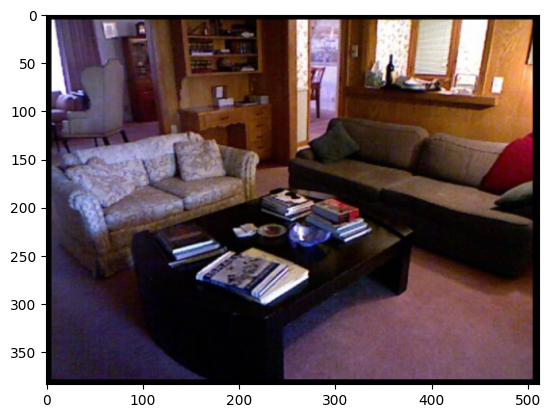

In [4]:
plt.imshow(img)

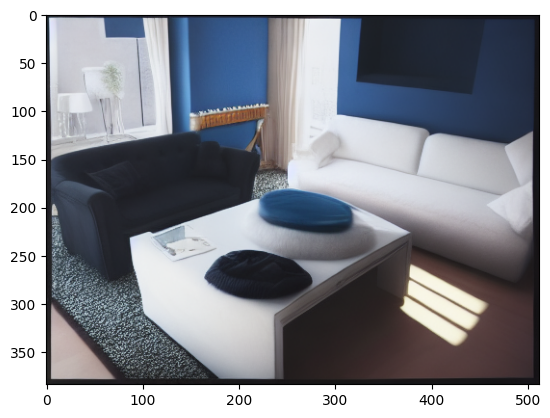

In [10]:
plt.imshow(results[2])

In [11]:
# detected_map_ = (1-control_org[:,:,0]).cpu().numpy()
mask = np.logical_and(pred_depth_image_zoe >= 1e-3, pred_depth_image_zoe <= 10)
detected_map_ = pred_depth_image_zoe
colors = (results[2]).reshape(-1, 3)[mask.reshape(-1)] / 255

from pointcloud_depth import depth_to_points
import open3d as o3d

pts3d = depth_to_points(detected_map_[np.newaxis, ...], fov=70)
pts3d = pts3d.reshape(-1, 3)[mask.reshape(-1)]

# create o3d point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d)
pcd.colors = o3d.utility.Vector3dVector(colors)

# write o3d point cloud
# o3d.io.write_point_cloud('sample/'+img_path.split('/')[7]+"_00000.ply", pcd)
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [29]:
pred_depth_image_zoe

array([[1.798354 , 1.8020093, 1.8071358, ..., 1.6531522, 1.647836 ,
        1.6439734],
       [1.80067  , 1.8047225, 1.8103678, ..., 1.6594679, 1.6532257,
        1.6488297],
       [1.8045323, 1.8090816, 1.8153672, ..., 1.6655264, 1.6590135,
        1.6544471],
       ...,
       [1.6186593, 1.6205751, 1.6199892, ..., 1.5208869, 1.5176845,
        1.5138013],
       [1.6056402, 1.6069206, 1.6051301, ..., 1.5140381, 1.5106802,
        1.5068777],
       [1.5954677, 1.5962981, 1.5943636, ..., 1.5095868, 1.5058906,
        1.5020422]], dtype=float32)